# Support Class 5 - Problem sheet 4

In [1]:
# Load some packages 
# (if you get an error, you need to install the package in the terminal)
import numpy as np                #scientific computing
from scipy.stats import multivariate_normal   #for probability distributions
from scipy.stats import norm                   #for probability distributions
import scipy.linalg               #for e'values/vectors
import matplotlib.pyplot as plt   #plotting
import seaborn as sns             #helps with data manipulation/plotting
#import math                       #calculating exponentials below

#### Question 2 -  Contact Process

Consider the contact processs $(\mathbf{\eta}_t : t \geq 0)$ with only nearest neighbour connections $q(i,j) = q(j,i) = \lambda \delta_{j,i+1}$ and periodic BCs.

Use the Gillespie (or random sequential update) algorithm to simulate the process with initial condition $\mathbf{\eta}_{t=0} = \mathbf{1}$


The rates of flipping the state i is:

$$ c(\mathbf{\eta} ,\mathbf{\eta}^i ) = \mathbf{\eta}(i) + \lambda \big( 1 - \mathbf{\eta}(i) \big) \big( \mathbf{\eta}(i+1) + \mathbf{\eta}(i-1) \big). $$

Therefore the rates at i are: 1 for recovery, $\lambda$ for infection with one infected neighbour, and $2\lambda$ for two infected neighbours.

First we set up the Gillespie algorithm.

In [2]:
#Define a function that runs the contact process

#Input parameters:
#sims = 10      #number of independent simulations
#λ = 1.62       #rate of infection
#L = 128        #number of individuals (states)
#tmax = 10*L    #maximum runtime
#step = 50      #number of time points to record the state η at  

def CP(sims,λ,L,tmax,steps):
    
    #time chunk after which we record the current state
    Δt = tmax/steps

    #store total infected (sum of all states) after each simulation (at each time)
    N = np.zeros((sims,steps+1))

    # loop for each simulation
    for i in range(0,sims):
        
        η = np.zeros((L,steps+1))   #array to store each state at each time chunk
        η[:,0] = 1                  #initially all start infected (1 = infected, 0 = recovered)
        
        #while loop to simuate Gillespie algorithm
        t = 0                    #initial time
        k = 1                    #time chunk counter
        state = np.ones((L,))    #current state of population (initially all infected)
        while t < tmax:
            
            #this loop carries out multiple Gillespie updates (save at each Δt)
            while t < k*Δt:
                
                #shifts the current state to use the formula above (incorporating BCs)
                state_plus = np.append(state[1:L],state[0])
                state_minus = np.append(state[L-1],state[0:L-1]) 

                #find contact rates for each state
                C = state + λ*(1 - state)*(state_plus + state_minus)
                R = np.sum(C)    #total rate
                p = C/R          #probabilities of flipping
                
                if R == 0.0:  #stops loop when no infected left
                    break

                #select a state at random according to the probabilities
                index = np.random.choice(range(0,L),1,replace=True,p = p)

                #flip the state
                state[index] = 1 - state[index]

                #increase the time (i.e. when the event occured)
                t = t + np.random.exponential(1/R)
                #then either do another update (if t < kΔt) or save the state
                
            η[:,k] = state  #save the state
            k = k + 1       #consider next time chunk

            if R == 0.0:  #stops loop when no infected left
                break
        
        
        #sum over states at each time and store the process N(t) (for this simulation)
        N[i,:] = np.sum(η,axis=0)
        
        #this statement check whether any of the final states were 'jumped' over
        # and saves the corresponding steps.
        if k < steps+1:
            N[i,k:steps+1] = N[i,k-1]
            

    return N

In [10]:
#Test it out:
sims = 5       #independent simulations
λ = 1.62       #rate of infection
L = 100        #number of individuals
tmax = 5*L    #maximum runtime
steps = 100     #number of output times (multiple recoveries/infections may occur in each delta t - avoid using a growing array)

N = CP(sims,λ,L,tmax,steps)

/tmp/ipykernel_74024/388755703.py:40: RuntimeWarning: invalid value encountered in true_divide
  p = C/R          #probabilities of flipping


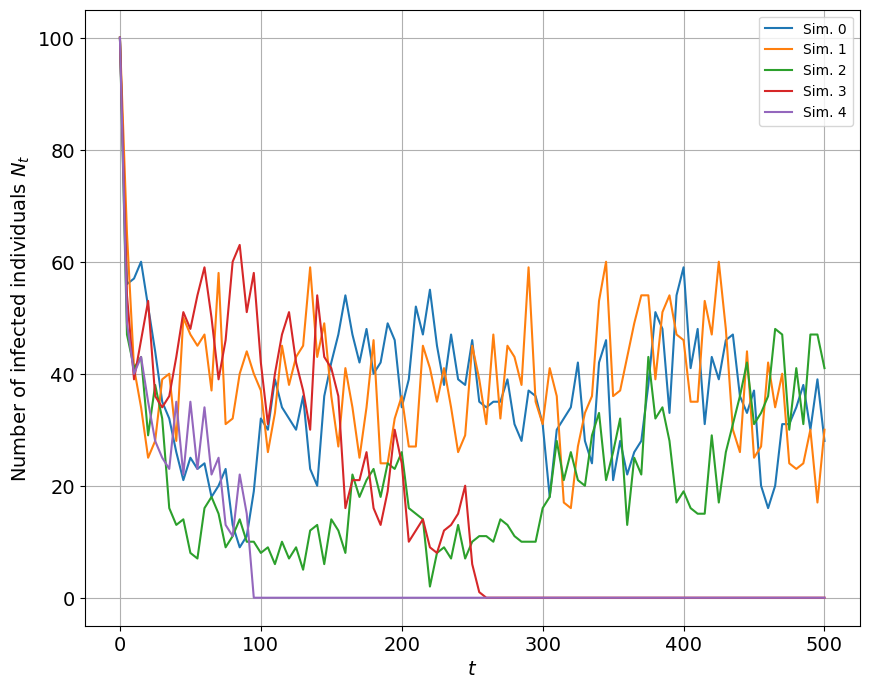

In [11]:
#plot the results
plt.figure(figsize=(10,8))
for sim in range(sims):
    plt.plot(np.arange(0,tmax+(tmax/steps),tmax/steps),N[sim,:],label='Sim. {}'.format(sim))
# plt.plot(np.arange(0,tmax+(tmax/steps),tmax/steps),N[3,:],label='Sim. 4')
# plt.plot(np.arange(0,tmax+(tmax/steps),tmax/steps),N[4,:],label='Sim. 5')
plt.legend()
plt.xlabel('$t$', fontsize = 14)
plt.ylabel('Number of infected individuals $N_t$', fontsize = 14)
plt.grid()
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

#### Question 2(a)(i)

Simulate the process for $L = 128, 256, 512, 1024$ and parameters λ = 1.62, . . . , 1.68 with 0.01 increments (7 values) with at least 500 realizations each.

For each $L$, plot the number of infected individuals $N_t = \sum_{i \in \Lambda_L} \mathbf{\eta}_t (i)$ averaged over realizations as a function of time up to time $10 × L$ for all values of λ above in a single double-logarithmic plot. Use the curvature of the plots to estimate $\lambda_c (L)$. 


In [12]:
def run_for_L_and_plot(L):
    sims = 5      #independent simulations
    λ = np.arange(1.62,1.69,0.01)
    tmax = 10*L     #maximum runtime
    steps = 100     #number of output times (multiple recoveries/infections may occur in each delta t - avoid using a growing array)

    N1 = CP(sims,λ[0],L,tmax,steps)
    N2 = CP(sims,λ[1],L,tmax,steps)
    N3 = CP(sims,λ[2],L,tmax,steps)
    N4 = CP(sims,λ[3],L,tmax,steps)
    N5 = CP(sims,λ[4],L,tmax,steps)
    N6 = CP(sims,λ[5],L,tmax,steps)
    N7 = CP(sims,λ[6],L,tmax,steps)

    N1 = np.sum(N1,axis=0)/sims
    N2 = np.sum(N2,axis=0)/sims
    N3 = np.sum(N3,axis=0)/sims
    N4 = np.sum(N4,axis=0)/sims
    N5 = np.sum(N5,axis=0)/sims
    N6 = np.sum(N6,axis=0)/sims
    N7 = np.sum(N7,axis=0)/sims
    
    #plot the results
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(0,tmax+1,tmax/steps),N1,label='$\lambda = 1.62$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N2,label='$\lambda = 1.63$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N3,label='$\lambda = 1.64$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N4,label='$\lambda = 1.65$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N5,label='$\lambda = 1.66$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N6,label='$\lambda = 1.67$')
    plt.plot(np.arange(0,tmax+1,tmax/steps),N7,label='$\lambda = 1.68$')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.xlabel('$t$', fontsize = 20)
    plt.ylabel('Number of infected individuals $N_t$', fontsize = 20)
    plt.grid()
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    
    return 

/tmp/ipykernel_74024/388755703.py:40: RuntimeWarning: invalid value encountered in true_divide
  p = C/R          #probabilities of flipping


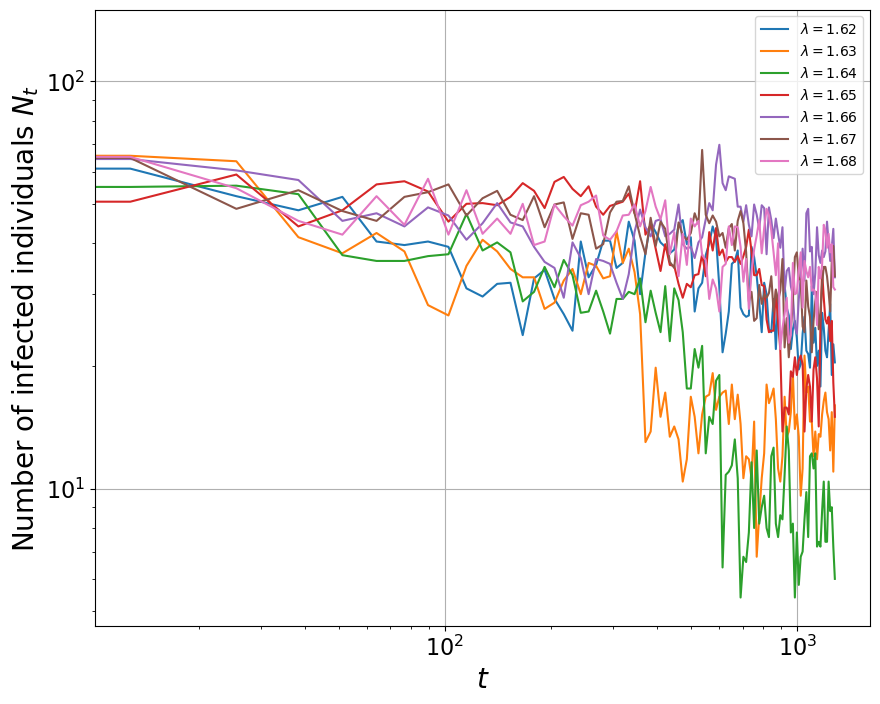

In [13]:
run_for_L_and_plot(128)

In [ ]:
run_for_L_and_plot(256)

In [ ]:
run_for_L_and_plot(512)

In [ ]:
run_for_L_and_plot(1024)

#### Question 2(a)(ii)

Plot your estimates of $\lambda_c (L)$ with error bars $\pm 0.01$ against $1/L$. Extrapolate to $1/L \rightarrow 0$ to get an estimate of $\lambda_c = \lambda_c (\infty)$ with a reasonable error bar.

This approach is called finite size scaling, in order to correct for systematic finite size
effects which influence the critical value.

ValueError: 'yerr' (shape: (4, 1)) must be a scalar or a 1D or (2, n) array-like whose shape matches 'y' (shape: (4,))

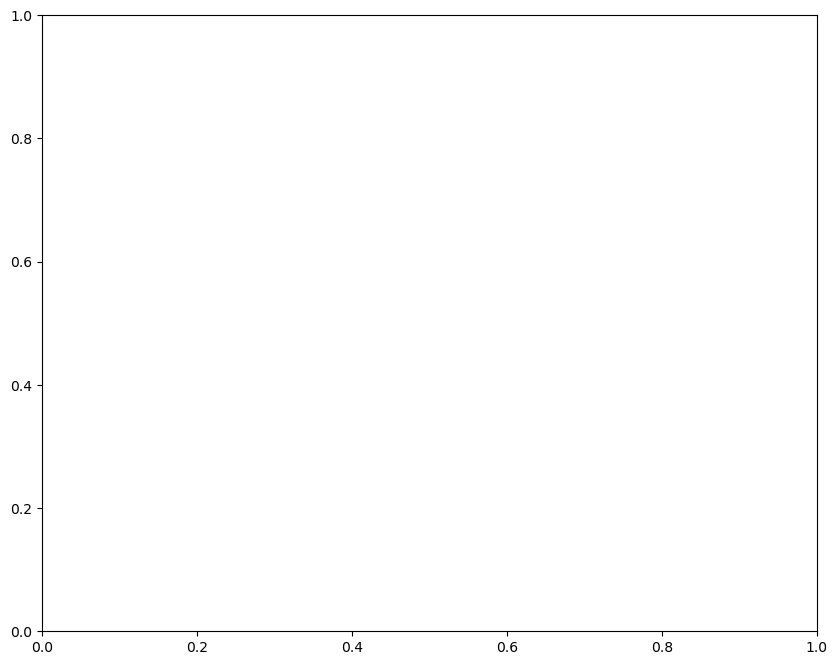

In [14]:
# Input parameters:
L = np.array([128,256,512,1024])
λc = np.array([1.65,1.63,1.621,1.62])  # <-- supposed to find these from plots above
errors = 0.01*np.ones((4,1))

#plot the results
plt.figure(figsize=(10,8))
plt.errorbar(1/L,λc,yerr = errors, fmt = 'ok', mew = 3)
plt.plot(1/L,λc,'-ok')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$1/L$', fontsize = 20)
plt.ylabel('$\lambda_c$', fontsize = 20)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 2(b)(i)

Let T be the hitting time of the absorbing state $\mathbf{\eta} = \mathbf{0}$, i.e. the lifetime of the infection. Measure the lifetime of the infection for λ = 1 and λ = 1.8 by running the process until extinction of the epidemic.

In [ ]:
# adapt CP above to find the extinction time

#Input parameters:
#sims = 10      #number of independent simulations
#λ = 1.62       #rate of infection
#L = 128        #number of individuals (states)


def CPextinction(sims,λ,L):

    #store extinction times after each simulation
    T = np.zeros((sims,1))

    # loop for each simulation
    for i in range(0,sims):
        
        #while loop to simuate Gillespie algorithm
        t = 0                    #initial time
        k = 1                    #time chunk counter
        state = np.ones((L,))    #current state of population (initially all infected)
        total_infec = L          #we only care about total infected
        while total_infec > 0:
                            
            #shifts the current state to use the formula above (incorporating BCs)
            state_plus = np.append(state[1:L],state[0])
            state_minus = np.append(state[L-1],state[0:L-1]) 

            #find contact rates for each state
            C = state + λ*(1 - state)*(state_plus + state_minus)
            R = np.sum(C)    #total rate
            p = C/R          #probabilities of flipping

            #select a state at random according to the probabilities
            index = np.random.choice(range(0,L),1,replace=True,p = p)

            #flip the state
            state[index] = 1 - state[index]

            #increase the time (i.e. when the event occured)
            t = t + np.random.exponential(1/R)

            #find total infections at current state
            total_infec = np.sum(state)        
        
        #store extinction time
        T[i,:] = t
            

    return T

In [ ]:
# Test:
sims = 5      #independent simulations
λ = 1         #rate of infection
L = 128       #number of individuals

T = CPextinction(sims,λ,L)
print(T)
print('Average = ',np.mean(T))

Use large system sizes e.g. L = 128, 256, 512, 1024 (or larger), confirm that $\mathbb{E}(T)$ scales like $\log(L)$ and determine $C$ by averaging at least 200 realizations of $T$ for each $L$ (takes a long time to run for 200 sims!).

In [ ]:
sims = 10      #independent simulations
λ = 1           #rate of infection
L1 = np.array([128,256,512,1024])       #number of individuals

T1 = CPextinction(sims,λ,L1[0])
T11 = np.mean(T1)
T2 = CPextinction(sims,λ,L1[1])
T22 = np.mean(T2)
T3 = CPextinction(sims,λ,L1[2])
T33 = np.mean(T3)
T4 = CPextinction(sims,λ,L1[3])
T44 = np.mean(T4)

In [ ]:
#plot the results
plt.figure(figsize=(10,8))
plt.plot(L1, np.array([T11,T22,T33,T44]),'-ob',label='Empirical values')
#plt.plot(L1, 10000*np.log(L1),label='$C = 10000$ in $C \log(L)$')
#plt.plot(L1, 50000*np.log(L1),label='$C = 50000$ in $C \log(L)$')
#plt.plot(L1, 100000*np.log(L1),label='$C = 100000$ in $C \log(L)$')

plt.yscale('log')
plt.legend()
plt.xlabel('$L$', fontsize = 20)
plt.ylabel('$\mathbb{E}(T)$', fontsize = 20)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 2(b)(ii)

Then shift your data $T_i$ for each $L$ by $T_i − \mathbb{E}(T)$ and plot the ‘empirical tail’ of the distribution of the shifted data, comparing to the Gumbel distribution (all in one plot with log-scale on the y-axis).

Recall: The empirical tail of data $T = (T_1,\dots,T_M)$ is the statistic tail $tail(T) =
(1/M) \sum_{i=1}^M \mathbb{1}_{T_i > t}$. This decays from 1 to 0 as a (random) function of time t.

Look up the Gumbel distribution on Wikipedia - with mean 0 only one parameter needs fitting. Discuss why this could be a good model for the noise here (check google for extreme value statistics)

Need more simulations to see larger $L$ converge to Gumbel.

In [ ]:
shift_T1 = T1 - T11
shift_T2 = T2 - T22
shift_T3 = T3 - T33
shift_T4 = T4 - T44  

tt = np.arange(-1000000,1000000+1,1000)


Tail_T1 = np.zeros((len(tt),1))
Tail_T2 = np.zeros((len(tt),1))
Tail_T3 = np.zeros((len(tt),1))
Tail_T4 = np.zeros((len(tt),1))
for i in range(0,len(tt)):
    Tail_T1[i] = (1/sims)*np.sum(shift_T1 > tt[i])
    Tail_T2[i] = (1/sims)*np.sum(shift_T2 > tt[i])
    Tail_T3[i] = (1/sims)*np.sum(shift_T3 > tt[i])
    Tail_T4[i] = (1/sims)*np.sum(shift_T4 > tt[i])
    

#plot the results
plt.figure(figsize=(10,8))
plt.plot(tt,Tail_T1,label='$L = 128$')
plt.plot(tt,Tail_T2,label='$L = 256$')
plt.plot(tt,Tail_T3,label='$L = 512$')
plt.plot(tt,Tail_T4,label='$L = 1024$')
plt.plot(tt,np.exp(-np.exp(tt/1)),'k',label='Gumbell CDF with beta = 1')
plt.legend()
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('Empirical tail distribution', fontsize = 20)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 2(c)(i)

For $\lambda = 1.8 > \lambda_c$ we expect $T \sim Exp(1/\mu)$ to be an exponential random variable with mean $\mu = \mathbb{E}(T) \varpropto e^{CL}$ for some $C>0$. 


Use *small* system sizes e.g. $L = 8, 10, 12, 14$ (see how far you can go), and
confirm that $\mathbb{E}(T)$ scales like $e^{CL}$. Determine $C$ by averaging at least 200 realizations of $T$ (takes a while to run for 200 sims!).

In [ ]:
sims = 5      #independent simulations
λ = 1.8         #rate of infection
L2 = np.array([8,10,12,14,16,18])       #number of individuals

TT1 = CPextinction(sims,λ,L2[0])
TT11 = np.mean(TT1)
TT2 = CPextinction(sims,λ,L2[1])
TT22 = np.mean(TT2)
TT3 = CPextinction(sims,λ,L2[2])
TT33 = np.mean(TT3)
TT4 = CPextinction(sims,λ,L2[3])
TT44 = np.mean(TT4)
TT5 = CPextinction(sims,λ,L2[4])
TT55 = np.mean(TT5)
TT6 = CPextinction(sims,λ,L2[5])
TT66 = np.mean(TT6)

In [ ]:
#plot the results
plt.figure(figsize=(10,8))
plt.plot(L2, np.array([TT11,TT22,TT33,TT44,TT55,TT66]),'-ob',label='Empirical values')
plt.plot(L2, np.exp(0.3*L2 + 1),label='$ e^{0.3*L + 1}$')
plt.yscale('log')
plt.legend()
plt.xlabel('$L$', fontsize = 20)
plt.ylabel('$\mathbb{E}(T)$', fontsize = 20)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

#### Question 2(c)(ii)

Then rescale your data $T_i$ for each $L$ by $T_i/\mathbb{E}(T)$ and plot the ‘empirical tail’ of the distribution of the rescaled data, comparing to the theoretical tail $e^{−t}$ (all in one plot with log-scale on the y-axis).



In [ ]:
scale_T1 = TT1/TT11
scale_T2 = TT2/TT22
scale_T3 = TT3/TT33
scale_T4 = TT4/TT44 
scale_T5 = TT5/TT55 
scale_T6 = TT6/TT66 

t = np.arange(0,8+1,0.01)


tail_T1 = np.zeros((len(t),1))
tail_T2 = np.zeros((len(t),1))
tail_T3 = np.zeros((len(t),1))
tail_T4 = np.zeros((len(t),1))
tail_T5 = np.zeros((len(t),1))
tail_T6 = np.zeros((len(t),1))
for i in range(0,len(t)):
    tail_T1[i] = (1/sims)*np.sum(scale_T1 > t[i])
    tail_T2[i] = (1/sims)*np.sum(scale_T2 > t[i])
    tail_T3[i] = (1/sims)*np.sum(scale_T3 > t[i])
    tail_T4[i] = (1/sims)*np.sum(scale_T4 > t[i])
    tail_T5[i] = (1/sims)*np.sum(scale_T5 > t[i])
    tail_T6[i] = (1/sims)*np.sum(scale_T6 > t[i])
    

#plot the results
plt.figure(figsize=(10,8))
plt.plot(t,tail_T1,label='$L = 8$')
plt.plot(t,tail_T2,label='$L = 10$')
plt.plot(t,tail_T3,label='$L = 12$')
plt.plot(t,tail_T4,label='$L = 14$')
plt.plot(t,tail_T5,label='$L = 16$')
plt.plot(t,tail_T6,label='$L = 18$')
plt.plot(t,np.exp(-t),label='$e^{-t}$')
plt.legend()
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('Empirical tail distribution', fontsize = 20)
plt.grid()
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)